<a href="https://colab.research.google.com/github/wdconinc/practical-computing-for-scientists/blob/master/Lectures/lecture13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture #13

##Standard Preamble

In [0]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math

##In our last episode

* Optimization
  * Minima and maxima of functions. Local and global.
  * Bracketing minima
  * The golden section search
  * Newton's method: $\Delta x = -f'(x)/f''(x)$ 
  

## The Newton method for scalar functions of one variable

As you know, from calculus, we can expand any well behaved function $f(x)$ in a series around a point $\bar{x}$:

$$f(x) = f(\bar{x}) + \frac{\partial f}{\partial x}\big|_\bar{x}(x-\bar{x}) + \frac{\partial^2 f}{\partial x^2}\big|_\bar{x} \frac{1}{2}(x-\bar{x})^2 $$

or with $\Delta x = x - \bar{x}$


$$f(x) = f(\bar{x} + \Delta x) = f(\bar{x}) + \frac{\partial f}{\partial x}\big|_\bar{x} \Delta x + \frac{\partial^2 f}{\partial x^2}\big|_\bar{x} \frac{1}{2} \Delta x^2 $$

We will successively improve our estimate of the minimum by choosing different points $\bar{x}_n$ that are closer to the minimum. We want $\bar{x}_n$ to be a stationary point, so that
$$ \frac{df(\bar{x} + \Delta x)}{d\Delta x} = 0$$

This happens when 
$$ \frac{\partial f}{\partial x}\big|_{\bar{x}_n} + \frac{\partial^2 f}{\partial x^2}\big|_{\bar{x}_n} \Delta x = 0 $$

So we update successively with this $\Delta x$:
$$ \bar{x}_{n+1} = \bar{x}_n + \Delta x =\bar{x}_n - \frac{\partial f}{\partial x}\big|_{\bar{x}_n} / \frac{\partial^2 f}{\partial x^2}\big|_{\bar{x}_n} $$


In [0]:
f = lambda x : (x - 0.25)**2

def D(f, x, h = 1e-6):
    temp = x+h
    h = temp-x
    return (f(x+h) - f(x-h)) / (2*h)

def DD(f, x, h = 1e-6):
    temp = x+h
    h = temp-x
    return (f(x+h) + f(x-h) - 2*f(x)) / h**2


def newton_optimize(f, xlow, xhigh, df = None, ddf = None, accuracy = 1e-6, nmax = 100):
    xbar = xlow
    fbar = f(xlow)
    fhigh = f(xhigh)
    if fhigh < fbar: 
        xbar, fbar = xhigh,fhigh

    # if user doesn't supply 1st and 2nd derivatives
    # make function objects to evaluate them
    if df == None:
        df = lambda x : D(f,x)
    if ddf == None:
        ddf = lambda x : DD(f,x)

    for i in range(nmax):
        x = xbar - df(xbar) / ddf(xbar)
        print(i, xbar, x, df(xbar), ddf(xbar))
        if math.fabs(x - xbar) < accuracy:
            return x, f(x)
        else:
            xbar = x
    raise ArithmeticError("Failed to converge")

In [0]:
print(newton_optimize(f, -1.0, +1.0))

0 1.0 0.24998340846627554 1.5 1.9999557568888162
1 0.24998340846627554 0.25 -3.318306744892752e-05 2.000000000000025
2 0.25 0.25 0.0 2.0
(0.25, 0.0)


## The Newton method for scalar functions of more than one variable

###The partial derivative

Consider the function $f(x_0,x_1,x_2) = 2 x_0 + 3 x_1 + 5 x_1 x_2$

It is easier to consider the arguments $x_i$ to be part of a single vector argument $\vec{x}$

In [0]:
def partial(f, i, h = 1e-6):
    ''' 
        Returns a function object to compute the partial derivative of f with respect to x[i].
        
        f(x) is assumed to be a scalar function of a vector or scalar argument x.
    '''
    def df(x, f = f, i = i, h = h):
        x = np.array(x, dtype = np.float64) # make a copy and assure the use of 64-bit floats
        x[i] += h
        f_plus = f(x)
        x[i] -= 2*h
        f_minus = f(x)
        return (f_plus - f_minus) / (2.0*h)
    # note, partial() returns a function object, not the result of the function
    return df

fmulti = lambda x: 2*x[0] + 3*x[1] + 5*x[1]*x[2]

In [0]:
df0 = partial(fmulti,0)
v = [1,1,1]
print(df0(v))

2.000000000279556


In [0]:
df1 = partial(fmulti,1)
df2 = partial(fmulti,2)
print(df1(v),df2(v))

7.999999999341867 4.999999999810711


In [0]:
df12 = partial(df1,2)
print(df12(v))

4.999556324492005


###A little bit about matrices

We now need to represent vector quantities such as $\nabla f(\vec{x})$ and the Hessian matrix $H$. This means using matrices and matrix algebra.  Here's a quick introduction:

In [0]:
import numpy.matlib as ml

# make a 2x2 (row x column) matrix
M = ml.matrix([[1,2],[3,4]])
print(M)
print(type(M))

[[1 2]
 [3 4]]
<class 'numpy.matrixlib.defmatrix.matrix'>


In [0]:
# make a 1x2 "matrix" (a.k.a. a row vector)
V = ml.matrix([1,2])
VT = ml.matrix([[1],[2]])
print(V)
print(V.T) # the transpose of V = a 2x1 matrix = a column vector

[[1 2]]
[[1]
 [2]]


In [0]:
print(VT)

[[1]
 [2]]


In [0]:
print(M.dot(V.T)) # the dot product
print(M.I) # the matrix inverse
print(M.I * M) # checking the inverse. * is a other way to take the dot product

[[ 5]
 [11]]
[[-2.   1. ]
 [ 1.5 -0.5]]
[[1.00000000e+00 0.00000000e+00]
 [1.11022302e-16 1.00000000e+00]]


###The gradient

In [0]:
def gradient(f, x, h = 1e-6):
    ''' return the gradient of f(x) as a column vector with length = len(x) '''
    v = ml.matrix([partial(f, i, h = h)(x) for i in range(len(x))], dtype = np.float64)
    return v.T

What is the gradient of $f(x_0,x_1,x_2) = 2 x_0 + 3 x_1 + 5 x_1 x_2$ at $\vec{x} = (1,1,1)$?

In [0]:
v = [1,1,1]
print(gradient(fmulti,v))

[[2.]
 [8.]
 [5.]]


###The Hessian matrix

$$\mathbf{H} = \begin{bmatrix}
\dfrac{\partial^{2}f}{\partial x_{1}^{2}} & \dfrac{\partial^{2}f}{\partial x_{1}\,\partial x_{2}} & \cdots & \dfrac {\partial^{2}f}{\partial x_{1}\,\partial x_{n}} \\[2.2ex]
\dfrac{\partial^{2}f}{\partial x_{2}\,\partial x_{1}} & \dfrac {\partial^{2}f}{\partial x_{2}^{2}} & \cdots & \dfrac {\partial^{2}f}{\partial x_{2}\,\partial x_{n}} \\[2.2ex]
\vdots & \vdots &\ddots &\vdots \\[2.2ex]
\dfrac{\partial^{2}f}{\partial x_{n}\,\partial x_{1}} & \dfrac {\partial^{2}f}{\partial x_{n}\,\partial x_{2}} & \cdots & \dfrac {\partial^{2}f}{\partial x_{n}^{2}}
\end{bmatrix}$$

In [0]:
def hessian(f, x, h = 1e-6):
    ''' returns the two dimensional matrix of second partial derivatives of f(x). a.k.a. the Hessian matrix '''
    v = [ 
          [ partial(partial(f,column),row)(x) for column in range(len(x)) ]
        for row in range(len(x))]
    mx = ml.matrix(v, dtype = np.float64)
    return ml.matrix(v,dtype = np.float64)

In [0]:
print(hessian(fmulti,v))

[[0.         0.         0.        ]
 [0.         0.         4.99955632]
 [0.         4.99955632 0.        ]]


Remember what we are trying to obtain! In analogy with the one-dimensional function increment $\Delta x = -f'(x) / f''(x)$ we now want

$$ \Delta\vec{x} = - [H f(\vec{x})]^{-1} \nabla f(\vec{x}) $$

So, for $f(\vec{x}) = f(x_0,x_1,x_2) = 2 x_0 + 3 x_1 + 5 x_1 x_2$ at $\vec{x} = (1,1,1)$ we expect to need the inverse of the Hessian:

In [0]:
print(hessian(fmulti,v).I)

LinAlgError: ignored

####A test function: $f(\vec{x})=(x-1)^2 + (y-2)^2$ 

Using obscure `numpy.mgrid` tricks instead of `numpy.meshgrid`... See https://docs.scipy.org/doc/numpy/reference/generated/numpy.mgrid.html

In [0]:
f = lambda x : (x[0] - 1)**2 + (x[1] - 2)**2
x0, x1 = np.mgrid[-2.5:3:101j, 0:4:101j]

In [0]:
print(x0,x1)

[[-2.5   -2.5   -2.5   ... -2.5   -2.5   -2.5  ]
 [-2.445 -2.445 -2.445 ... -2.445 -2.445 -2.445]
 [-2.39  -2.39  -2.39  ... -2.39  -2.39  -2.39 ]
 ...
 [ 2.89   2.89   2.89  ...  2.89   2.89   2.89 ]
 [ 2.945  2.945  2.945 ...  2.945  2.945  2.945]
 [ 3.     3.     3.    ...  3.     3.     3.   ]] [[0.   0.04 0.08 ... 3.92 3.96 4.  ]
 [0.   0.04 0.08 ... 3.92 3.96 4.  ]
 [0.   0.04 0.08 ... 3.92 3.96 4.  ]
 ...
 [0.   0.04 0.08 ... 3.92 3.96 4.  ]
 [0.   0.04 0.08 ... 3.92 3.96 4.  ]
 [0.   0.04 0.08 ... 3.92 3.96 4.  ]]


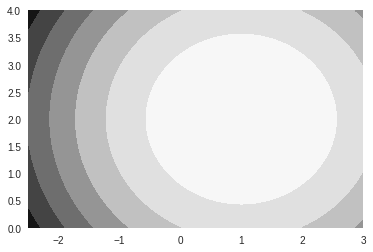

In [0]:
plt.contourf(x0, x1, f([x0,x1]))

####The `multi_newton` function

In [0]:
def multi_newton(f, xguess, h = 1e-6, accuracy = 1e-6, nmax = 100, want_points = False, debug = False, gamma = 1.0):
    xbar = ml.matrix(xguess, dtype = np.float64).T # to get a column vector
    xpoints = [xbar.A1[0]]
    ypoints = [xbar.A1[1]]
    for i in range(nmax):
        H = hessian(f, xbar.A1)
        grad = gradient(f, xbar.A1) # to get a column vector
        if debug:
            print("iteration ", i)
            print("xbar", xbar)
            print("grad=", grad)
            print("H=", H)
            print("H.I=", H.I)
            print("H.I.dot(grad)", H.I.dot(grad))
        x = xbar - gamma * H.I.dot(grad)
        if debug: print("x=", x)
        xpoints.append(x.A1[0])
        ypoints.append(x.A1[1])
        if np.sum((x.A1 - xbar.A1)**2) < accuracy**2:
            if not want_points:
                return x.A1
            else:
                return x.A1, xpoints, ypoints
        else:
            xbar = x
    raise ArithmeticError("Failed to converge")

In [0]:
multi_newton(f, [1,1])

array([1., 2.])

In [0]:
multi_newton(f, [1,1], debug = True)

iteration  0
xbar [[1.]
 [1.]]
grad= [[ 0.]
 [-2.]]
H= [[1.99995576 0.        ]
 [0.         1.99998351]]
H.I= [[ 0.50001106 -0.        ]
 [ 0.          0.50000412]]
H.I.dot(grad) [[ 0.        ]
 [-1.00000824]]
x= [[1.        ]
 [2.00000824]]
iteration  1
xbar [[1.        ]
 [2.00000824]]
grad= [[-1.11023148e-16]
 [ 1.64881136e-05]]
H= [[2. 0.]
 [0. 2.]]
H.I= [[ 0.5 -0. ]
 [ 0.   0.5]]
H.I.dot(grad) [[-5.55115739e-17]
 [ 8.24405679e-06]]
x= [[1.]
 [2.]]
iteration  2
xbar [[1.]
 [2.]]
grad= [[-1.11022239e-16]
 [-1.55431226e-15]]
H= [[2.00000000e+00 1.00974196e-16]
 [1.00974196e-16 2.00000000e+00]]
H.I= [[ 5.0000000e-01 -2.5243549e-17]
 [-2.5243549e-17  5.0000000e-01]]
H.I.dot(grad) [[-5.55111195e-17]
 [-7.77156128e-16]]
x= [[1.]
 [2.]]


array([1., 2.])

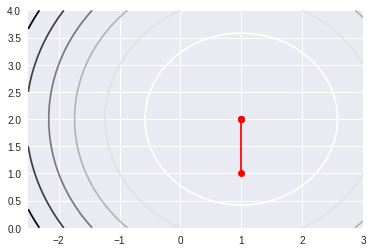

In [0]:
minx, x0points, x1points = multi_newton(f, [1,1], want_points = True)

plt.contour(x0, x1, f([x0,x1]))
plt.plot(x0points, x1points, '-or')

####A somewhat more difficult test function

In [0]:
fharder = lambda x : 1 - x[0]*np.exp(-x[0]) + (x[1] - 2)**2

####Testing `multi_newton` on the new test function

[1.8, -2.1983358501279326, -1.4365352011962584, -0.7274950710460142, -0.0941298905775868, 0.42835729020751223, 0.7920926146505111, 0.9642127195718708, 0.9987703048382844, 0.9999985711336329, 0.9999999998775031, 1.0000000000284008] [2.8, 1.9998713237523558, 2.000000045209486, 1.999999999916413, 2.000000000027438, 1.9999999999719271, 1.9999999999996825, 1.9999999999996825, 1.9999999999996825, 1.9999999999996825, 1.9999999999996825, 1.9999999999996825]


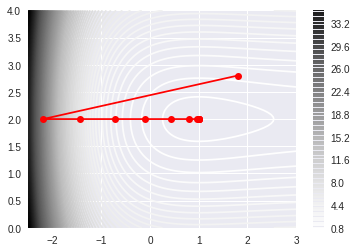

In [0]:
minx, x0points, x1points = multi_newton(fharder, [1.8,2.8], want_points = True)
x0, x1 = np.mgrid[-2.5:4:101j, 0:4:101j]
cs = plt.contour(x0, x1, fharder([x0,x1]), 100)
plt.colorbar(cs)
print(x0points, x1points)
plt.plot(x0points, x1points, "-or")